# Audio features extration

## Perceived Loudness

To figure out a way to compute a measure of **percieved loudness** of an audio segment.

Before computing percieved loudness, let us try to compute a simple measure of loudness which is directly linked to a physical attribute called intensity. \
**Intensity** is a physical measure of loudness which is proportional to square of the amplitude of the signal.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
from getLoudness import loadAudioSignal

### Load the audio signal

In [84]:
# x, sr = loadAudioSignal(audioFp=Path("../tmp/intezaar.wav"))
x, sr = librosa.load("../tmp/convertedAudios/espresso.wav", sr=16000)
x = x[0:50*sr] # first 100 seconds of the audio

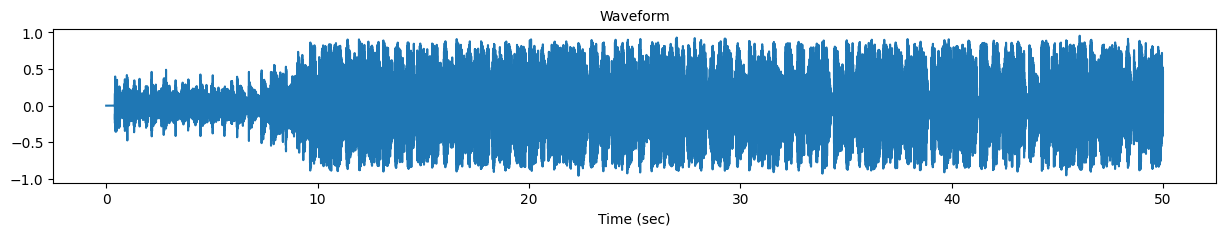

In [85]:
plt.figure(figsize=(15, 2))
plt.plot(np.arange(len(x))/sr, x)
plt.title("Waveform", size=10)
plt.xlabel("Time (sec)")
plt.show()

### Computing Intensity

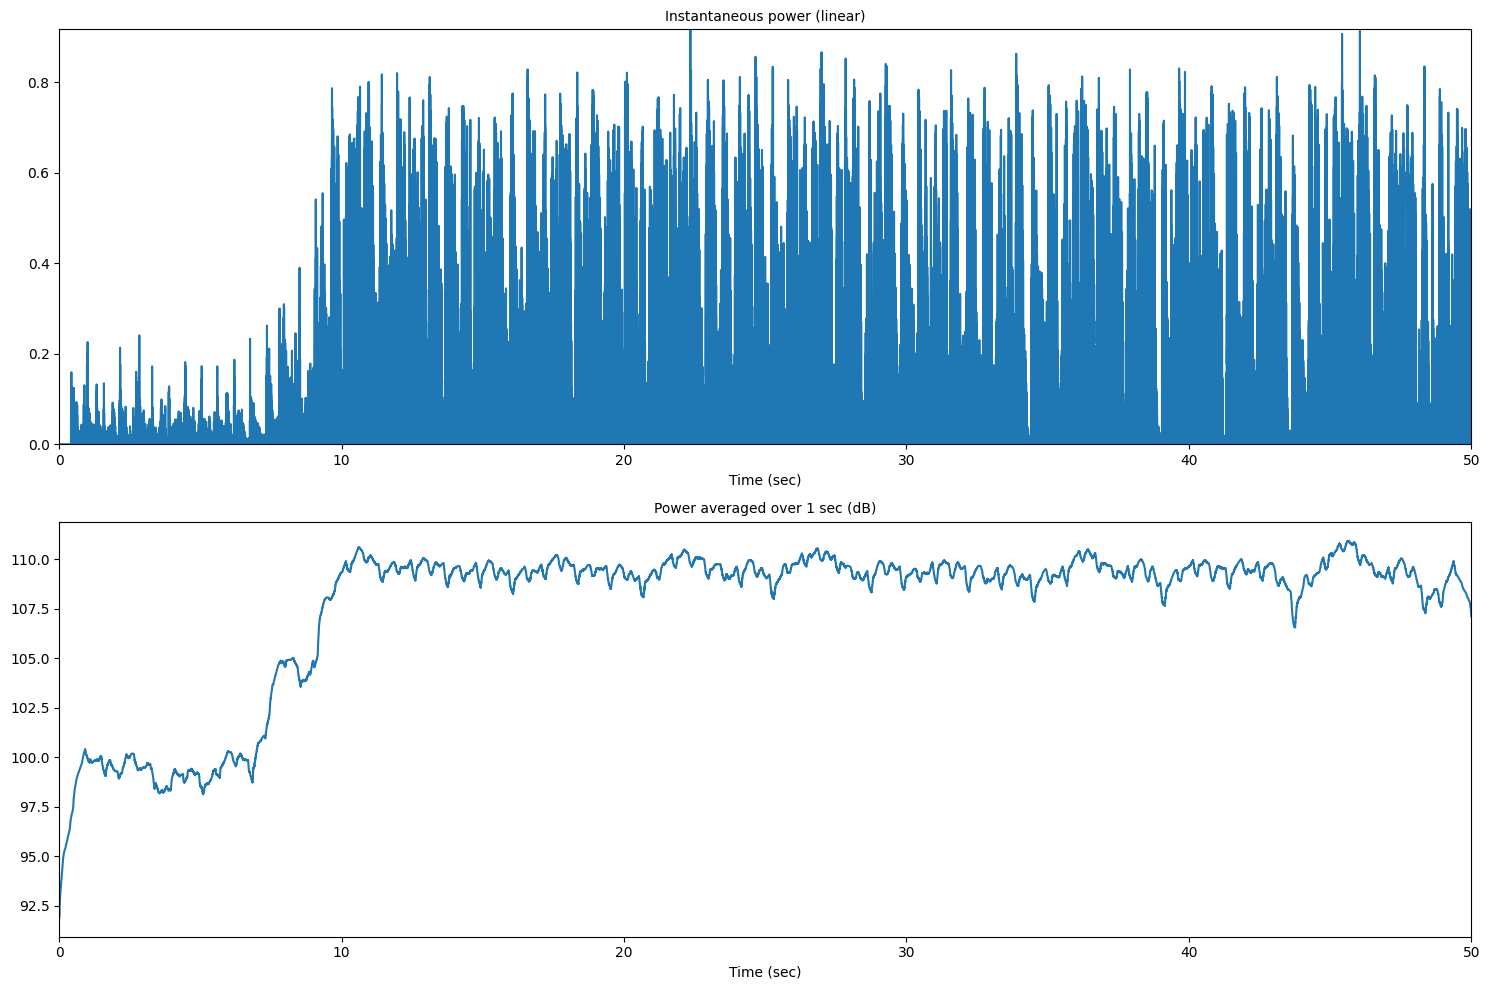

In [88]:
# instantaneous power (linear domain)
power = x**2  # instantaneous power

# average power
winSec = 1  # 1 sec window
winLen = int(winSec * sr)  # window size in samples
win = np.ones(winLen) / winLen  # averaging window
powerAvg = np.convolve(power, win, mode="same")  # average in linear domain
powerRef = 1e-12  # power reference
powerAvgdB = 10 * np.log10(powerAvg / powerRef)  # convert to dB

# Plotting
fig, ax = plt.subplots(figsize=(15, 10), nrows=2)

# instantaneous power (linear)
ax[0].plot(np.arange(len(power)) / sr, power)
ax[0].set_title("Instantaneous power (linear)", size=10)
ax[0].set_xlabel("Time (sec)")
ax[0].set_ylim([np.min(power), np.max(power)])

# averaged power (dB)
ax[1].plot(np.arange(len(powerAvgdB)) / sr, powerAvgdB)
ax[1].set_title(f"Power averaged over {winSec} sec (dB)", size=10)
ax[1].set_xlabel("Time (sec)")

zoom = [0, 50]
ax[0].set_xlim(zoom)
ax[1].set_xlim(zoom)

plt.tight_layout()
plt.show()


This can act as a measure of loudness but what we percieve as loudness has also to do with energy distibution in different frequency bands. Our ears have different sensitivity for different frequencies. In order to accomodate for that, we need two things:
1. A measure of our ears sensitivity for different frequencies.
2. A way to normalise in order to get a measure of percieved loudness.

### Equal loudness contour

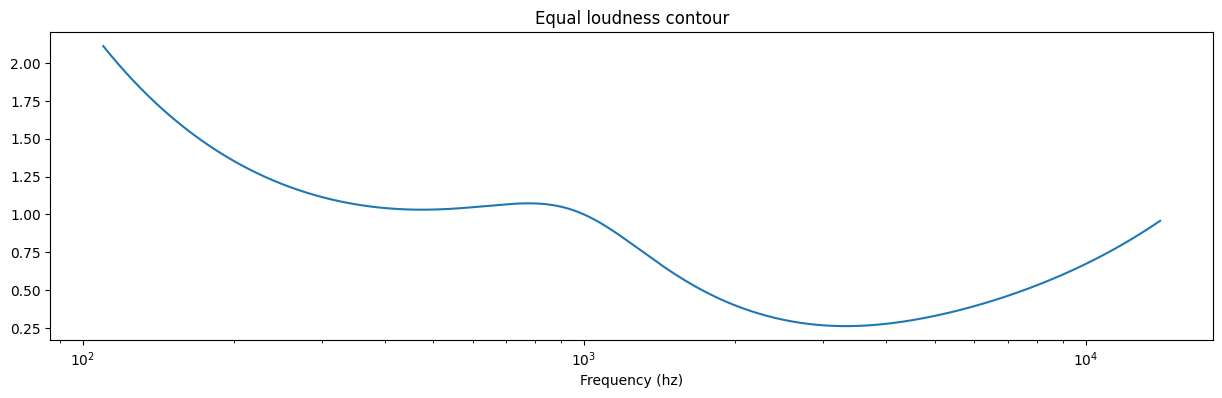

In [96]:
def getEqualLoudnessContour(freqs):
	"""
	Code taken from https://www.audiolabs-erlangen.de/resources/MIR/FMP/C1/C1S3_Dynamics.html to find equal loudness contour
	Parameters
    ----------
	freqs: ndarray 
        Frequencies at which to sample the equal intensity contour
	Returns
    -------
    equalLoudnessContour: ndarray
        Amplitudes at corresponding frequencies that are equal in intensity
	"""
	freq = 1000 # This is the reference frequency (considering at an amplitude 1), the distribution is with respect to this
	hFreq = ((1037918.48 - freq**2)**2 + 1080768.16 * freq**2) / ((9837328 - freq**2)**2 + 11723776 * freq**2)
	nFreq = (freq / (6.8966888496476 * 10**(-5))) * np.sqrt(hFreq / ((freq**2 + 79919.29) * (freq**2 + 1345600)))
	hFreqRange = ((1037918.48 - freqs**2)**2 + 1080768.16 * freqs**2) / ((9837328 - freqs**2)**2
																					+ 11723776 * freqs**2)
	nFreqRange = (freqs / (6.8966888496476 * 10**(-5))) * np.sqrt(hFreqRange / ((freqs**2 + 79919.29) *
																		(freqs**2 + 1345600)))
	equalLoudnessContour = np.abs(nFreq / nFreqRange)
	return equalLoudnessContour

freqs = 110*2**(np.linspace(0, 7, sr*5)) # jump one octave every equal time interval
equalLoudnessContour = getEqualLoudnessContour(freqs=freqs)

plt.figure(figsize=(15, 4))
plt.title("Equal loudness contour")
plt.plot(freqs, equalLoudnessContour)
plt.xscale("log")
plt.xlabel("Frequency (hz)")
plt.show()

### Mel Spectrogram

In [202]:
getEqualLoudnessContour(100)

np.float64(2.2917289124186087)

In [104]:
N = 2048  # FFT window size
H = 512   # Hop length
n_mels = 128  # Number of mel bands

# generate mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=N, win_length=N, hop_length=H, n_mels=n_mels)

# Get Mel frequencies
mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sr/2)

# Compute the equal loudness contour for Mel frequencies (ensure this function is defined)
equal_loudness_contour = getEqualLoudnessContour(mel_frequencies)

# Avoid division by zero by adding a small epsilon to the contour
epsilon = 1e-10
equal_loudness_contour = equal_loudness_contour + epsilon

# Normalize the Mel spectrogram
normalized_mel_spec = mel_spec / equal_loudness_contour[:, np.newaxis]  # Check the shape of equal_loudness_contour

# Convert to dB scale
mel_spec_db = librosa.power_to_db(normalized_mel_spec, ref=np.max)

# Compute the loudness (summed dB) over time
loudnessdB = np.sum(librosa.power_to_db(mel_spec, ref=np.max), axis=0)
loudnessdBNorm = np.sum(librosa.power_to_db(normalized_mel_spec, ref=np.max), axis=0)

/var/folders/ld/vxqh6sm16lncp33yprd672hh0000gn/T/ipykernel_39524/3281163112.py:20: RuntimeWarning: divide by zero encountered in divide
  equalLoudnessContour = np.abs(nFreq / nFreqRange)


In [109]:
equal_loudness_contour

array([       inf, 9.06103878, 4.58403758, 3.11495796, 2.39730789,
       1.97967969, 1.71155449, 1.52841456, 1.39801575, 1.30247201,
       1.23108363, 1.177073  , 1.1359494 , 1.10462637, 1.08091605,
       1.06322493, 1.05036314, 1.04142069, 1.03568469, 1.03258254,
       1.03164195, 1.03246237, 1.03469411, 1.03802313, 1.04215982,
       1.04683096, 1.05177429, 1.05673517, 1.06146521, 1.06572262,
       1.06927415, 1.07189833, 1.07338982, 1.07356444, 1.07226449,
       1.06936381, 1.06477205, 1.05843775, 1.05034976, 1.04053676,
       1.02906502, 1.01603434, 1.00157271, 0.98520431, 0.96713518,
       0.94752773, 0.92652705, 0.90430232, 0.88104032, 0.85693849,
       0.83219811, 0.80701799, 0.78158898, 0.75608963, 0.73068304,
       0.70551474, 0.68071176, 0.65638249, 0.63261728, 0.60948956,
       0.5870573 , 0.56536469, 0.54444387, 0.52431671, 0.50499642,
       0.48648918, 0.46879546, 0.45191135, 0.43582963, 0.42054066,
       0.40603328, 0.39229537, 0.37931443, 0.36707802, 0.35557

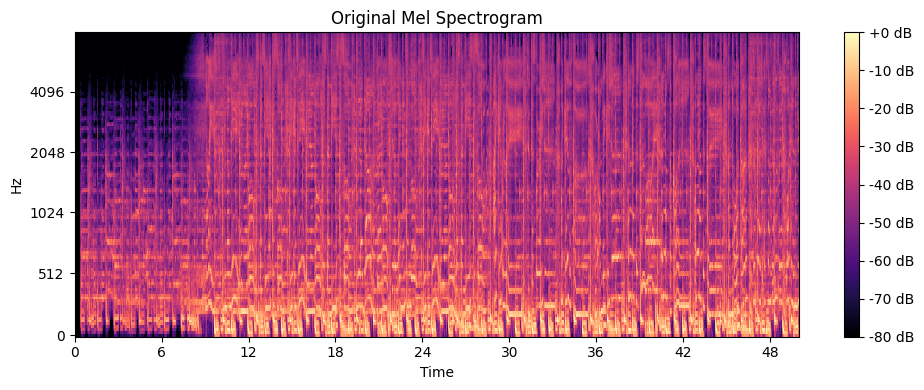

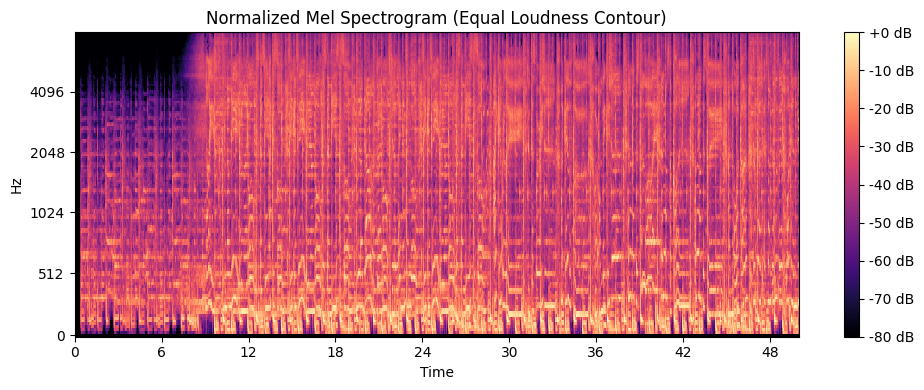

In [105]:
# Original Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), sr=sr, hop_length=H, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Mel Spectrogram')
plt.tight_layout()
plt.show()

# Normalized Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(normalized_mel_spec, ref=np.max), sr=sr, hop_length=H, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Normalized Mel Spectrogram (Equal Loudness Contour)')
plt.tight_layout()
plt.show()

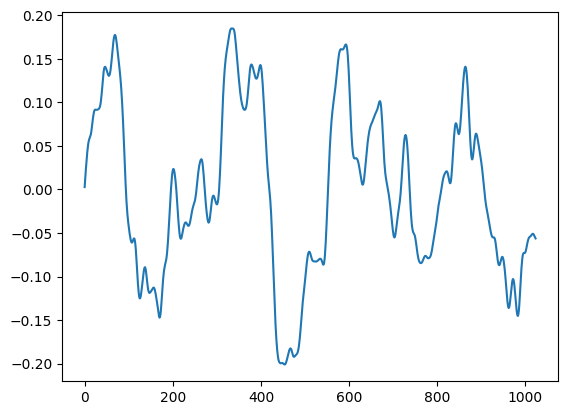

In [208]:
plt.plot(x[50000:51024])

In [241]:
vals = np.abs(np.fft.fft(x[50000:51024]))
fs = np.fft.fftfreq(n=vals.shape[0], d=1/sr)

In [224]:
vals.shape

(1024,)

In [226]:
fs

array([   0.        ,   43.06640625,   86.1328125 , ..., -129.19921875,
        -86.1328125 ,  -43.06640625])

(0.0, 1000.0)

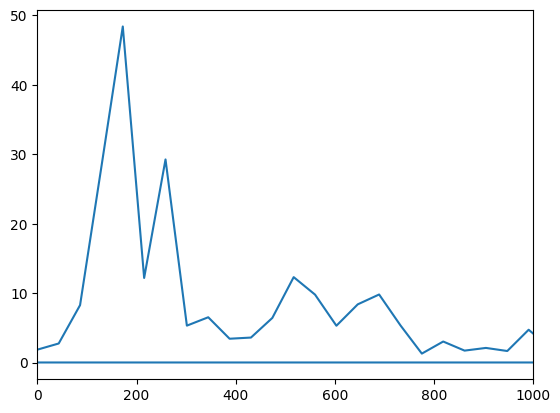

In [229]:
plt.plot(fs, vals)
plt.xlim(0, 1000)

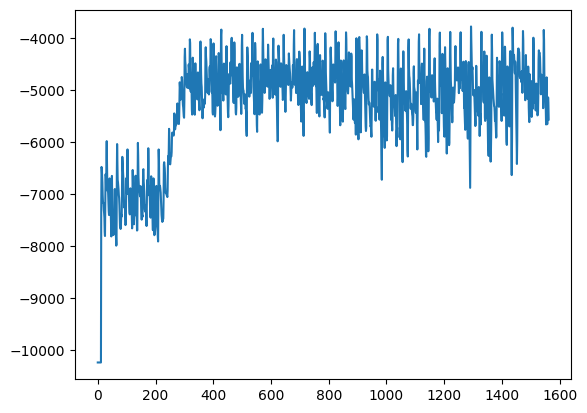

In [106]:
plt.plot(loudnessdB)

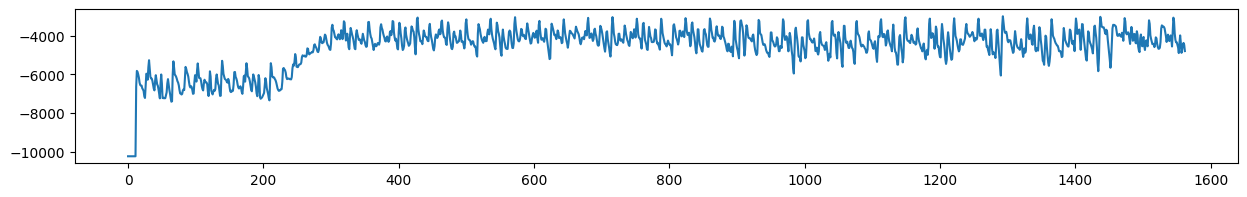

In [107]:
plt.figure(figsize=(15, 2))
plt.plot(loudnessdBNorm)

Equal loudness contour

In [108]:
loudnessdBNorm

array([-10240.        , -10240.        , -10240.        , ...,
        -4369.29466594,  -4468.65216692,  -4791.56217542])

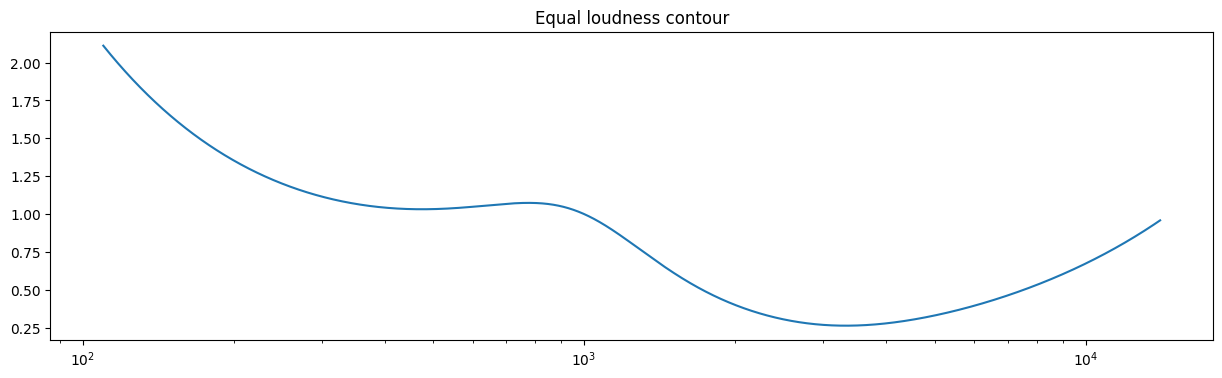

Compute mel spectrogram

In [386]:
sr = 16000
dur = 5

f0 = 10
ts = np.linspace(0, 5, int(sr*dur))
xs = 10*np.sin(2*np.pi*f0*ts) + 20*np.sin(2*np.pi*(f0+20)*ts)

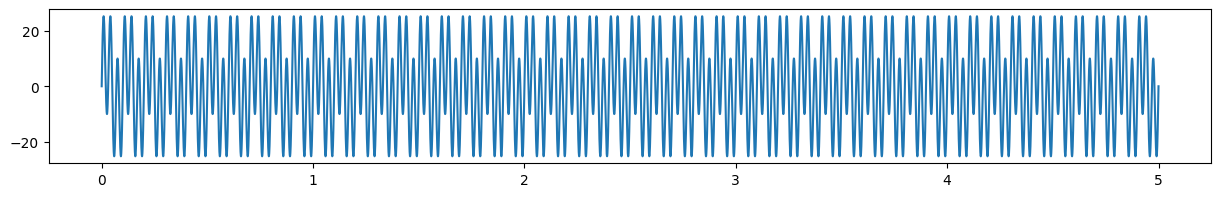

In [387]:
plt.figure(figsize=(15, 2))
plt.plot(ts, xs)
plt.show()

In [388]:
X = np.abs(np.fft.fft(xs)) 
X /= (X.shape[0]/2)
fs = np.fft.fftfreq(n=X.shape[0], d=1/sr)

In [389]:
fs[fs>0][0:100]

array([ 0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,
        2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,
        4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,
        6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,
        9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. ,
       11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2,
       13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2, 15.4,
       15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4, 17.6,
       17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6, 19.8,
       20. ])

In [390]:
X[2:4]

array([1.66835787e-05, 2.50577470e-05])

(0.0, 50.0)

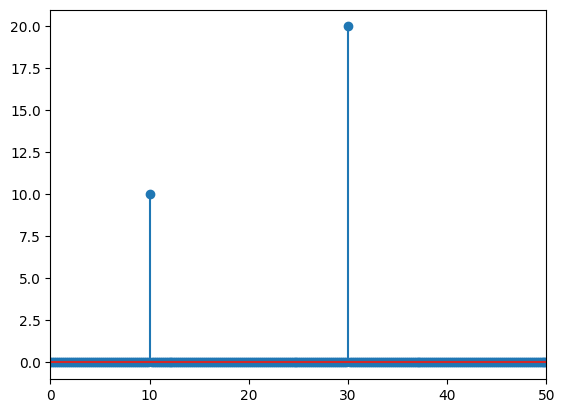

In [391]:
plt.stem(fs, X)
plt.xlim(0, 50)

In [398]:
X = np.abs(np.fft.fft(xs[:4096*2]))
X /= (X.shape[0]/2)
fs = np.fft.fftfreq(n=X.shape[0], d=1/sr)

In [400]:
fs[fs>=0]

array([0.00000000e+00, 1.95312500e+00, 3.90625000e+00, ...,
       7.99414062e+03, 7.99609375e+03, 7.99804688e+03])

In [394]:
X.shape

(8192,)

(0.0, 100.0)

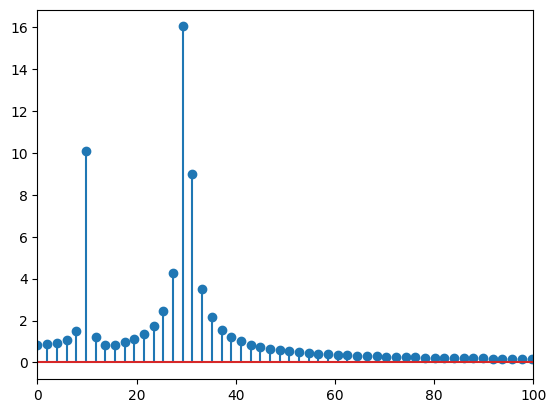

In [395]:
plt.stem(fs, X)
plt.xlim(0, 100)

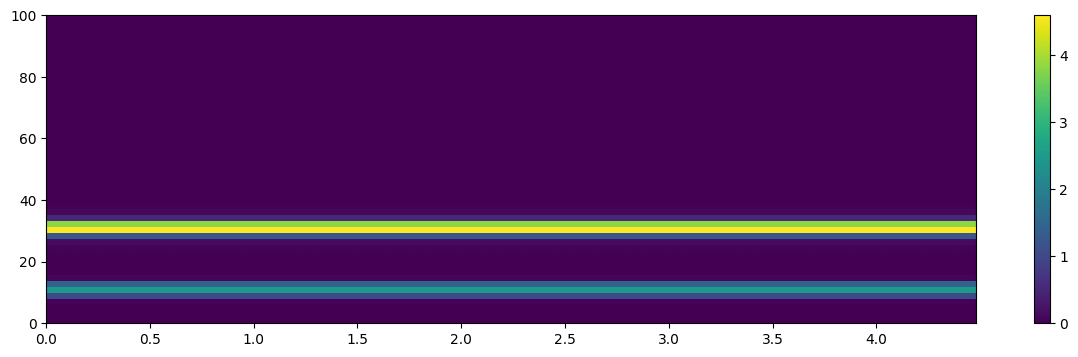

In [419]:
spec = librosa.stft(y=xs, n_fft=4096*2, win_length=4096*2, hop_length=512, center=False)
spec /= (4096*2)
ts = np.arange(spec.shape[1]) * (512/sr)
fs = np.arange(spec.shape[0]) * (sr/(4096*2))

plt.figure(figsize=(15, 4))
plt.imshow(np.abs(spec), origin="lower", aspect="auto", extent=[ts[0], ts[-1], fs[0], fs[-1]])
plt.colorbar()
plt.ylim(0, 100)
plt.show()

In [426]:
fs[(fs>10)&(fs<40)]

array([11.71875 , 13.671875, 15.625   , 17.578125, 19.53125 , 21.484375,
       23.4375  , 25.390625, 27.34375 , 29.296875, 31.25    , 33.203125,
       35.15625 , 37.109375, 39.0625  ])

(0.0, 40.0)

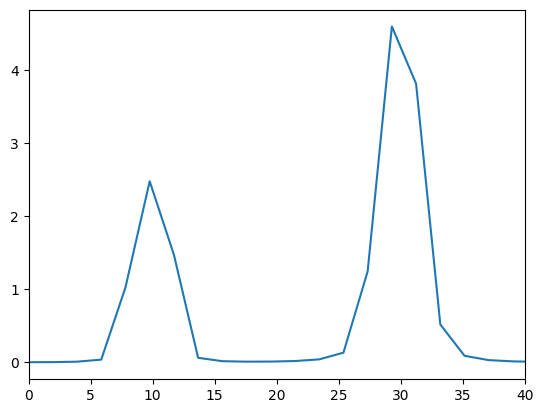

In [431]:
plt.plot(fs, np.abs(spec[:,10]))
plt.xlim([0, 40])

In [379]:
spec.shape

(2049, 149)

In [292]:
fs = np.arange(spec.shape[0]) * (sr/2048)

In [294]:
fs

array([0.0000000e+00, 7.8125000e+00, 1.5625000e+01, ..., 7.9843750e+03,
       7.9921875e+03, 8.0000000e+03])

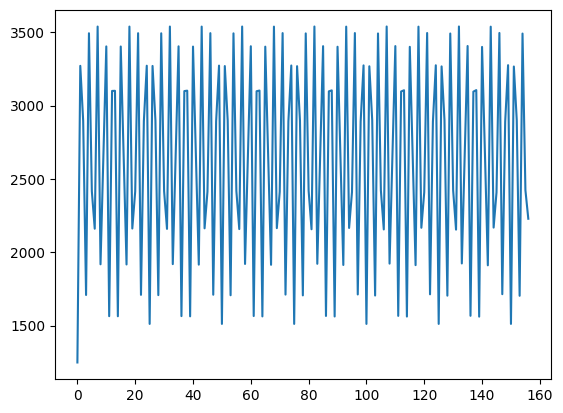

In [297]:
plt.plot(np.abs(spec)[1,:])

## Energy Distribution across frequencies

In [117]:
# load audio signal
x, sr = librosa.load("../tmp/espresso.mp3", sr=None)
print(f"{np.round(len(x)/sr)} sec at {sr} hz")

174.0 sec at 44100 hz


In [182]:
# loading the spectrogram
NSec, HSec = 0.060, 0.010 # in sec
gamma = 30 # log compression
N, H = round(NSec*sr), round(HSec*sr)
spec = librosa.stft(y=x, n_fft=N, win_length=N, hop_length=H)
powerSpec = np.abs(spec)**2 # power spectrum (linear)
eps = np.finfo(float).eps
powerSpecdB = 10 * np.log10(powerSpec + eps) # power spectrum (dB)

fs = np.arange(spec.shape[0]) * (sr/N)
ts = np.arange(spec.shape[1]) * (H/sr)

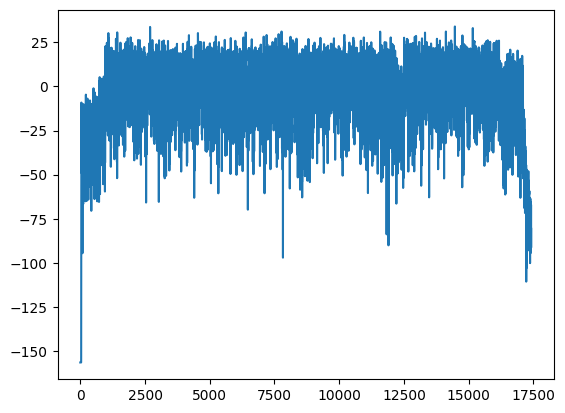

In [191]:
plt.plot(powerSpecdB[0,:])

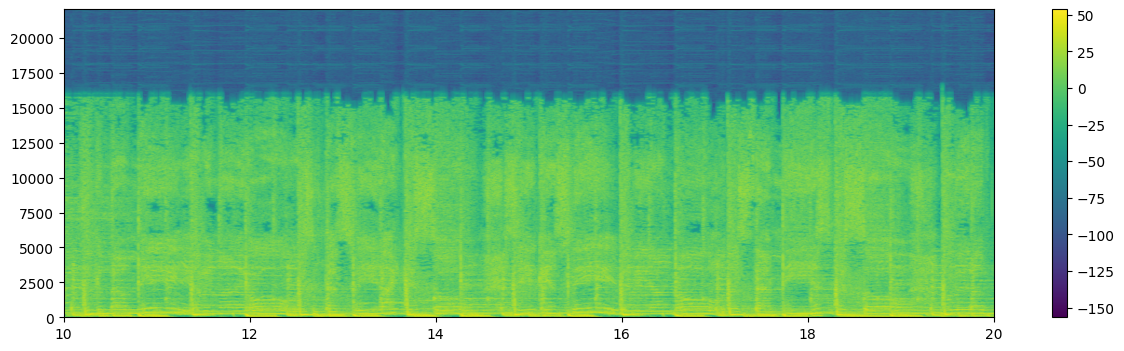

In [184]:
plt.figure(figsize=(15, 4))
plt.imshow(powerSpecdB, origin="lower", aspect="auto", extent=[ts[0], ts[-1], fs[0], fs[-1]])
plt.colorbar()
plt.xlim(10, 20)
plt.show()

In [185]:
powerSpec = np.abs(spec)**2

In [197]:
energyDistribution = np.sum(powerSpecdB, axis=1)

In [193]:
powerSpec[10,:]

array([0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 6.406543e-08,
       3.111222e-08, 7.501252e-09], dtype=float32)

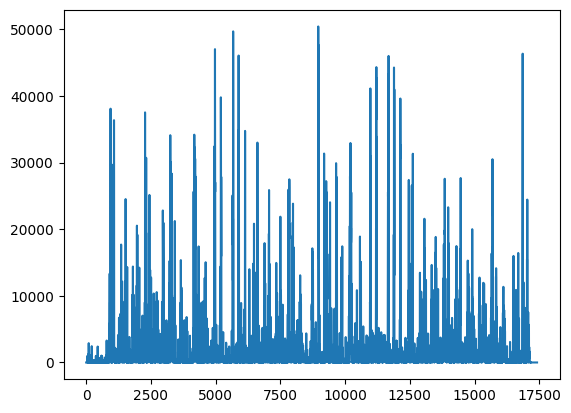

In [195]:
plt.plot(powerSpec[16,:])

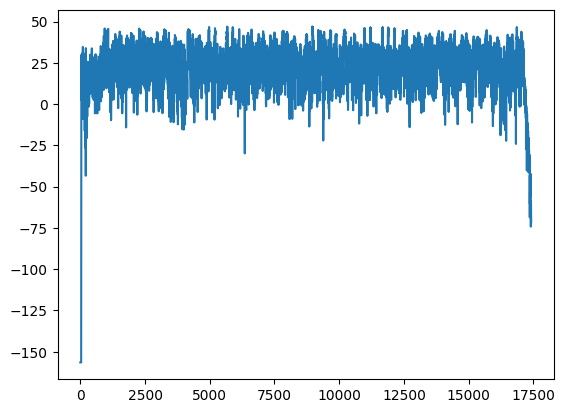

In [196]:
plt.plot(powerSpecdB[16,:])

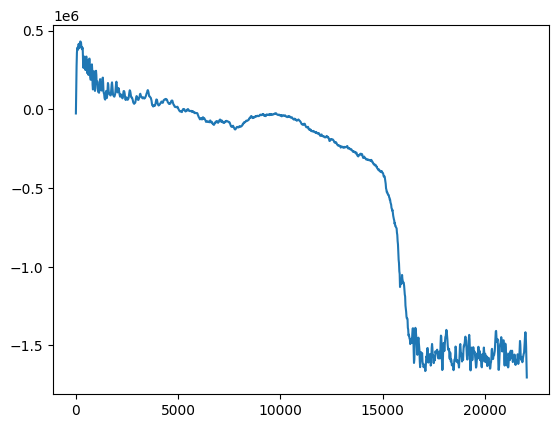

In [200]:
plt.plot(fs, energyDistribution)
# plt.xlim([1000,20000])
# plt.ylim([0, 100000])